# PS2: Logistic Regression Classification of a Clinical Dataset
In this problem set, we will classify a dataset describing the clinical risk factors linked with death from heart disease using [Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression). In this dataset, several risk factors (features) are measured per patient (some of these features are continuous, some are categorical), along with the binary clinical outcome (target variable) `{death | not death}.`  

In particular, we will compare a classifier trained using [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) with a classifier trained [using simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing#:~:text=Simulated%20annealing%20(SA)%20is%20a,can%20find%20the%20global%20optimum.) (which doesn't require the computation of derivatives). Work you way through the notebook, correct any issues that occur and answer the discussion questions at the end of the notebook.

## Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.

In [3]:
include("Include.jl");

### Data
Next, let's load up the dataset that we will explore. The data for this lab was taken from this `2020` publication:
* [Davide Chicco, Giuseppe Jurman: "Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone." BMC Medical Informatics and Decision Making 20, 16 (2020). https://doi.org/10.1186/s12911-020-1023-5](https://pubmed.ncbi.nlm.nih.gov/32013925/)

In this paper, the authors analyzed a dataset of `299` heart failure patients collected in 2015. The patients comprised 105 women and 194 men, aged between 40 and 95 years old. The dataset contains `13` features (a mixture of continuous/categorical data and the label), which report clinical, body, and lifestyle information:
* Some features are binary: anemia, high blood pressure, diabetes, sex, and smoking status.
* The remaining features were continuous biochemical measurements, such as the level of the Creatinine phosphokinase (CPK) enzyme in the blood, the number of platelets, etc.
* The class (target) variable is encoded as a binary (boolean) death event: `1` if the patient died during the follow-up period, `0` if the patient did not die during the follow-up period.

We'll load this dataset as a [DataFrame instance](https://dataframes.juliadata.org/stable/) and store it in the `originaldataset::DataFrame` variable:

In [5]:
originaldataset = CSV.read(joinpath(_PATH_TO_DATA, "heart_failure_clinical_records_dataset.csv"), DataFrame)

Row,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,death_event
,Float64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Int64,Int64,Int64,Int64,Int64
1,75.0,0,582,0,20,1,265000.0,1.9,130,1,0,4,1
2,55.0,0,7861,0,38,0,263358.0,1.1,136,1,0,6,1
3,65.0,0,146,0,20,0,162000.0,1.3,129,1,1,7,1
4,50.0,1,111,0,20,0,210000.0,1.9,137,1,0,7,1
5,65.0,1,160,1,20,0,327000.0,2.7,116,0,0,8,1
6,90.0,1,47,0,40,1,204000.0,2.1,132,1,1,8,1
7,75.0,1,246,0,15,0,127000.0,1.2,137,1,0,10,1
8,60.0,1,315,1,60,0,454000.0,1.1,131,1,1,10,1
9,65.0,0,157,0,65,0,263358.0,1.5,138,0,0,10,1


#### Data rangling
We know from lecture that our classification algorithms work on [`Matrix` instance](https://docs.julialang.org/en/v1/base/arrays/#Base.Matrix-Tuple{UndefInitializer,%20Any,%20Any}) and not [`DataFrame` instances](https://dataframes.juliadata.org/stable/). Thus, we need to convert the data to [a `Matrix`](https://docs.julialang.org/en/v1/base/arrays/#Base.Matrix-Tuple{UndefInitializer,%20Any,%20Any}). In addition, there are several ways we can pretreat the data to make the classification easier.
* Convert `0,1` data to `-1,1`. This is a preference (not technically required), but it makes (binary) classification problems easier, so let's convert all categorical `0,1` data to `-1,1`. In this rescaled data, `0` will be replaced by `-1`. Thus, _false_ (no death event) will be mapped to `-1`, and _true_ (death event) will remain `1`.
* Next, let's [z-score center](https://en.wikipedia.org/wiki/Feature_scaling) the continous feature data. In [z-score feature scaling](https://en.wikipedia.org/wiki/Feature_scaling), we subtract off the mean of each feature and then divide by the standard deviation, i.e., $x^{\prime} = (x - \mu)/\sigma$ where $x$ is the unscaled data, and $x^{\prime}$ is the scaled data. Under this scaling regime, $x^{\prime}\leq{0}$ will be values that are less than or equal to the mean value $\mu$, while $x^{\prime}>0$ indicate values that are greater than the mean. The range of data is measured in quanta of the standard deviation $\sigma$.

In [7]:
(D, dataset) = let

    # convert 0,1 into -1,1
    treated_dataset = copy(originaldataset);
    transform!(treated_dataset, :anaemia => ByRow(x -> (x==0 ? -1 : 1)) => :anaemia); # maps anaemia to -1,1
    transform!(treated_dataset, :diabetes => ByRow(x -> (x==0 ? -1 : 1)) => :diabetes); # maps diabetes to -1,1
    transform!(treated_dataset, :high_blood_pressure => ByRow(x -> (x==0 ? -1 : 1)) => :high_blood_pressure); # maps high_blood_pressure to -1,1
    transform!(treated_dataset, :sex => ByRow(x -> (x==0 ? -1 : 1)) => :sex); # maps sex to -1,1
    transform!(treated_dataset, :smoking => ByRow(x -> (x==0 ? -1 : 1)) => :smoking); # maps smoking to -1,1
    transform!(treated_dataset, :death_event => ByRow(x -> (x==0 ? -1 : 1)) => :death_event); # maps death_event to -1,1
    
    D = treated_dataset[:,1:end] |> Matrix; # build a data matrix from the DataFrame
    (number_of_examples, number_of_features) = size(D);

    # Which cols do we want to rescale?
    index_to_z_scale = [
        1 ; # 1 age
        3 ; # 2 creatinine_phosphokinase
        5 ; # 3 ejection_fraction
        7 ; # 4 platelets
        8 ; # 5 serum_creatinine
        9 ; # 6 serum_sodium
        12 ; # 7 time
    ];

    D̂ = copy(D);
    for i ∈ eachindex(index_to_z_scale)
        j = index_to_z_scale[i];
        μ = mean(D[:,j]); # compute the mean
        σ = std(D[:,j]); # compute std

        # rescale -
        for k ∈ 1:number_of_examples
            D̂[k,j] = (D[k,j] - μ)/σ;
        end
    end
    
    D̂, treated_dataset
end;

In [8]:
D

299×13 Matrix{Float64}:
  1.19095    -1.0   0.000165451  -1.0  …   1.0  -1.0  -1.62678   1.0
 -0.490457   -1.0   7.50206      -1.0      1.0  -1.0  -1.60101   1.0
  0.350246   -1.0  -0.449186     -1.0      1.0   1.0  -1.58812   1.0
 -0.910808    1.0  -0.485257     -1.0      1.0  -1.0  -1.58812   1.0
  0.350246    1.0  -0.434757      1.0     -1.0  -1.0  -1.57524   1.0
  2.452       1.0  -0.551217     -1.0  …   1.0   1.0  -1.57524   1.0
  1.19095     1.0  -0.346124     -1.0      1.0  -1.0  -1.54947   1.0
 -0.0701056   1.0  -0.275011      1.0      1.0   1.0  -1.54947   1.0
  0.350246   -1.0  -0.437849     -1.0     -1.0  -1.0  -1.54947   1.0
  1.6113      1.0  -0.47289      -1.0      1.0   1.0  -1.54947   1.0
  1.19095     1.0  -0.516176     -1.0  …   1.0   1.0  -1.54947   1.0
  0.098035   -1.0  -0.361583     -1.0      1.0   1.0  -1.54947   1.0
 -1.33116     1.0   0.411384     -1.0      1.0  -1.0  -1.53659   1.0
  ⋮                                    ⋱         ⋮              
 -1.33116    -

Next, split that dataset `D` into `training` and `test` subsets. We do this randomly, where the `number_of_training_examples::Int64` variable specifies the number of training points. The `training::Array{Float64,2}` data will be used to estimate the model parameters, and `test::Array{Float64,2}` will be used for model testing.

In [10]:
training, test = let

    number_of_training_examples = 199; # set the number to set the number of training examples
    number_of_examples = size(D,1); # number of rows in the full dataset
    full_index_set = range(1,stop=number_of_examples,step=1) |> collect |> Set;
    
    # build index sets for training and testing
    training_index_set = Set{Int64}();
    should_stop_loop = false;
    while (should_stop_loop == false)
        i = rand(1:number_of_examples);
        push!(training_index_set,i);

        if (length(training_index_set) == number_of_training_examples)
            should_stop_loop = true;
        end
    end
    test_index_set = setdiff(full_index_set,training_index_set);

    # build the test and train datasets -
    training = D[training_index_set |> collect,:];
    test = D[test_index_set |> collect,:];

    # return
    training, test
end;

### Compute the covariance
Compute the covariance array $\mathbf{\Sigma}$ of the z-scored centered (complete) dataset `D`. This will be a $m\times{m}$ symmetric array, i.e., a square matrix with the number of features (excluding the label) rows and columns. We calculate this array using [the `cov(...)` method exported by the `Statistics.jl` package](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.cov). 

In [12]:
Σ = cov(D[:,1:end-1])

12×12 Matrix{Float64}:
  1.0         0.0873213  -0.0815839   …   0.0174608   -0.224068
  0.0873213   0.98449    -0.189256       -0.0995713   -0.140313
 -0.0815839  -0.189256    1.0             0.00226468  -0.00934565
 -0.0998138  -0.0124801  -0.00952414     -0.136024     0.0333253
  0.0600984   0.0313113  -0.0440796      -0.0629621    0.0417292
  0.0892094   0.0362281  -0.0675033   …  -0.0498305   -0.18785
 -0.0523544  -0.0434447   0.0244634       0.0264088    0.0105139
  0.159187    0.0517674  -0.0164085      -0.0256416   -0.149315
 -0.0459658   0.0415555   0.0595502       0.00450198   0.08764
  0.0625685  -0.0899194   0.0763016       0.398824    -0.0149257
  0.0174608  -0.0995713   0.00226468  …   0.874863    -0.0213622
 -0.224068   -0.140313   -0.00934565     -0.0213622    1.0

Finally, let's set up the color dictionary to visualize the classification datasets. The keys of the `my_color_dictionary::Dict Int64, RGB` dictionary class labels, i.e., $ y\in\{1,-1\}$ while the values are the colors mapped to that label.

In [14]:
my_color_dictionary = Dict{Int64,RGB}();
my_color_dictionary[1] = colorant"#03045e"; # color for Label = 1
my_color_dictionary[-1] = colorant"#e36414"; # color for Label = -1

## Task 1: Visualize the clinical dataset using Principle Component Analysis (PCA)
In this task, you will reduce the dimension of the scaled dataset so that we can plot it in in two dimensions.
Imagine that we have $m$-dimensional features $\mathbf{x}\in\mathbb{R}^{m}$ that we want to reduce to a set of new composite feature vectors with a smaller dimension $\mathbf{y}\in\mathbb{R}^{k}$ where $k\ll{m}$. We have a `12` feature dimension, but we want to project this into `2` dimensions to visualize the label pattern.

We can do that using a special transformation matrix $\mathbf{P}\in\mathbb{R}^{k\times{m}}$
$$
\begin{equation}
\mathbf{y} = \mathbf{P}\cdot\mathbf{x}
\end{equation}
$$
The rows of $\mathbf{P}$ are a set of transformation vectors $\phi^{\top}_{i}\in\mathbb{R}^{1\times{m}}$ that _convert_ the features in $\mathbf{x}$ into the $y_{i}\,\text{for}\,i=1,2,\dots{k}$ components of the new compostite feature vector:
$$
\begin{equation}
y_{i} = \phi_{i}^{\top}\cdot\mathbf{x}\quad\text{for}\,i=1,2,\dots,k
\end{equation}
$$
Wow, that sounds great! We can take high-dimensional things and reduce them to only a few dimensions. What are these magical transformation vectors $\phi_{i}^{\top}$? The
$\texttt{TLDR}$ version of this story is that they are the eigenvectors of the covariance matrix corresponding to the largest $k$-eigenvalues, and this magical transformation is called [principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis).

Compute the transformation matrix $\mathbf{P}$, which we'll save in the `PM::Array{Float64,2}` variable:

In [16]:
PM = let
    
    F = eigen(Σ);
    λ = F.values;
    V = F.vectors;

    # get the largest and next largets eigenvectors
    v₁ = V[:,end]; # largest
    v₂ = V[:,end-1]; # next largest

    # build the projection matrix -
    PM = [
        transpose(v₁) ;
        transpose(v₂)
    ];

    # return -
    PM
end;

Next, compute the reduced dataset. The resulting reduced feature matrix, which we store in the `D̄::Array{Float64,2}` variable, will have dimensions of $n\times{2}$, where $n$ is the number of data points (rows) in the scaled dataset.

In [18]:
D̄ = let

    # setup -
    number_of_examples = size(D,1); # how many examples do we have (rows)
    number_of_features = size(D,2); # how many features do we have (cols)?
    X = D[:,1:end-1]; # features: need to add a 1 to each row (for bias), after removing the label

    # compute reduced feature vectors
    FV = PM*transpose(X) |> transpose |> Matrix

    # return
    FV
end;

In [19]:
D̄

299×2 Matrix{Float64}:
 -2.36816    0.771137
  1.12508    2.64884
 -1.85064    2.37096
 -1.23054    0.57269
 -2.56352   -0.991468
 -3.64502    0.440068
 -2.15218    0.779238
 -0.540169  -0.285765
 -0.251944  -1.2575
 -5.77253    0.102474
 -3.5222     0.257129
 -0.969141   1.45525
 -0.561031   0.719301
  ⋮         
  2.89239   -1.3517
  1.99249   -0.549911
  0.436389  -1.28156
  2.93543   -0.933155
  0.843638   1.27955
  2.1335     1.22098
  0.563842   1.0266
  1.0889     1.02204
  2.10683    0.232404
  4.27359   -1.5238
  1.95118    2.77718
  1.59968    1.63599

### Visualize
`Unhide` the code block below to see how we plotted the reduced dataset $\bar{D}$ and each point's associated label. 
* __Summary__: The dark blue points have label `1`, i.e., this patient had a death event during the follow-up period of the study. On the other hand, orange labels denote patients with label `-1`, i.e., patients that did not suffer a death event during the follow-up period of the study.

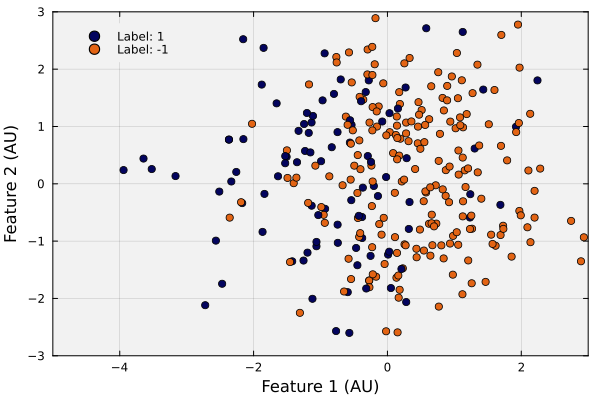

In [21]:
let
    dataset = D; # what dataset am I looking at?
    actual = D[:,end];
    number_of_points = size(dataset,1); # number of rows
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    
    # plot label = 1
    testlabel = 1;
    i = findfirst(label -> label == testlabel,  actual)
    c = my_color_dictionary[testlabel]
    scatter!([D̄[i,1]], [D̄[i,2]], label="Label: $(testlabel)", c=c)

    # plot label = -1
    testlabel = -1;
    i = findfirst(label -> label == testlabel,  actual)
    c = my_color_dictionary[testlabel]
    scatter!([D̄[i,1]], [D̄[i,2]], label="Label: $(testlabel)", c=c)
    
    # data -
    for i ∈ 1:number_of_points
        actuallabel = actual[i]; # actual label
        c = my_color_dictionary[actuallabel]
        scatter!([D̄[i, 1]], [D̄[i, 2]], label="", mec=:navy, c=c, xlims=(-5,3), ylims=(-3,3))
    end

    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
end

In [22]:
do_I_see_the_PCA_plot = true; # TODO: update this flag {true | false}

## Task 2: Logistic Regression using Gradient Descent
In this task, we build and train a [Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) classifier using the training data, and then challenge this classifier using the `test` dataset. We'll use [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) for parameter estimation.

We implemented [the `MyLogisticRegressionClassificationModel` type](src/Types.jl), which contains data required to solve the logistic regression problem, i.e., parameters, the learning rate, a stopping tolerance parameter $\epsilon$, and a loss (objective) function that we want to minimize. 
* __Technical note__: We approximated the gradient calculation using [a forward finite difference](https://en.wikipedia.org/wiki/Finite_difference). This is generally not a great idea. This is one of my super pet peeves with gradient descent; computing the gradient is (usually) a hassle. Typically, we must do at least two function evaluations to approximate the gradient well. Why do finite differences? It is easy to implement.

In the code below, we [build a `model::MyLogisticRegressionClassificationModel` instance using a `build(...)` method](src/Factory.jl). The model instance initially has a random guess for the classifier parameters. We use gradient descent to refine that guess [using the `learn(...)` method](src/Compute.jl), which returns the updated model instance in the `model_logistic_gd::MyLogisticRegressionClassificationModel` variable.

In [24]:
model_logistic_gd = let

    # data -
    D = training; # What dataset are we going to use?
    number_of_examples = size(D,1); # how many examples do we have (rows)
    number_of_features = size(D,2); # how many features do we have (cols)?
    X = [D[:,1:end-1] ones(number_of_examples)]; # features: need to add a 1 to each row (for bias), after removing the label
    y = D[:,end]; # output: this is the target data (label)

    # model
    model = build(MyLogisticRegressionClassificationModel, (
        parameters = 0.01*ones(number_of_features), # initial value for the parameters: these will be updated
        learning_rate = 0.01, # you pick this
        ϵ = 1e-4, # you pick this (this is also the step size for the fd approx to the gradient)
        loss_function = (x,y,θ) -> log10(1+exp(-y*(dot(x,θ)))) # what??!? Wow, that is nice. Yes, we can pass functions as args!
    ));

    # train -
    model = learn(X,y,model, maxiter = 10000, verbose = true); # this is learning the model parameters

    # return -
    model;
end;

Stopped after number of iterations: 10001. We have error: 28.74306767556523


__Inference__: Let's use the updated `model_logistic_gd::MyLogisticRegressionClassificationModel` instance (with parameters learned from the `training` data) and test how well we can classify data in the `test` dataset.

* We run the classification operation on the (unseen) test data [using the `classify(...)` method](src/Compute.jl). This method takes a feature array `X` and the (trained) model instance. It returns the probability of a label in the `P::Array{Float64,2}` array (which is different than the Perceptron). Each row of `P` corresponds to a test instance, in which each column corresponds to a label, in the case `1` and `-1`.

We store the actual (correct) label in the `y_logistic_gd::Array{Int64,1}` vector. We compute the predicted label for each test instance by finding the highest probability column. We store the predicted labels in the `ŷ_logistic_gd::Array{Int64,1}` vector.

In [26]:
ŷ_logistic_gd,y_logistic_gd, P = let

    D = test; # What dataset are you going to use?
    number_of_examples = size(D,1); # how many examples do we have (rows)
    number_of_features = size(D,2); # how many features do we have (cols)?
    X = [D[:,1:end-1] ones(number_of_examples)]; # features: need to add a 1 to each row (for bias), after removing the label
    y = D[:,end]; # output: this is the *actual* target data (label)

    # compute the estimated labels -
    P = classify(X,model_logistic_gd) # logistic regression returns a x x 2 array holding the probability

    # convert the probability to a choice ... for each row (test instance), compute the col with the highest probability
    ŷ = zeros(number_of_examples);
    for i ∈ 1:number_of_examples
        a = argmax(P[i,:]); # col index with largest value
        ŷ[i] = 1; # default
        if (a == 2)
            ŷ[i] = -1;
        end
    end
    
    # return -
    ŷ, y, P
end;

__Performance__: Once we have has converged (or exhasted our iterations), we can evaluate the binary classifier's performance using various metrics. The central idea is to compare the predicted labels $\hat{y}_{i}$ to the actual labels $y_{i}$ in the `test` dataset and measure wins (when the label is the same) and losses (label is different). This is easily represented in [the confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
* We compute confusion matrix [using the `confusion(...)` method](src/Compute.jl) and store it in the `CM_logistic_gd::Array{Int64,2}` variable. The [`confusion(...)` method](src/Compute.jl) takes the actual labels and the computed labels and returns the confusion matrix.

In [28]:
CM_logistic_gd = confusion(y_logistic_gd, ŷ_logistic_gd) # actual, predicted

2×2 Matrix{Int64}:
 19  12
  7  62

## Task 3: Logistic Regression using Simulated Annealing
In this task, we build and train a [Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) classifier using the `training` dataset, and then challenge this classifier using the `test` dataset. However, in this case we'll use [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing#:~:text=Simulated%20annealing%20(SA)%20is%20a,can%20find%20the%20global%20optimum.) for parameter estimation (instead of [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent)).

[Simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing#:~:text=Simulated%20annealing%20(SA)%20is%20a,can%20find%20the%20global%20optimum.) is a probabilistic optimization technique used to estimate the global optimum of a given function in large search spaces _without_ computing the gradient. It is particularly effective for problems with numerous local optima. 

__How does it work__? The [simulated annealing algorithm](https://github.com/varnerlab/CHEME-5820-Lectures-Spring-2025/blob/main/lectures/week-3/L3c/docs/Notes.pdf) generates a random parameter set and evaluates its loss function with the parameter set. This loss is compared with the best found so far. If the net loss decreases, the candidate parameter set becomes the best. However, if the net loss increases, the candidate set may be discarded (and a new candidate generates) or kept with a probability proportional to a temperature $T$. The temperate decreases (cools) with iteration count; thus, at high $T$, we are more likely to accept an uphill move. However, the probability of an uphill move decreases as the temperature decreases.

The pseudocode for simulated annealing can be found in [L3c course notes](https://github.com/varnerlab/CHEME-5820-Lectures-Spring-2025/blob/main/lectures/week-3/L3c/docs/Notes.pdf). 
* We implemented [the `MyLogisticRegressionSimulatedAnnealingClassificationModel` type](src/Types.jl), which contains data required to train the logistic regression problem using simulated annealing. To build this type, we [use a `build(...)` method](src/Factory.jl) and pass in an initial value for the parameters, a cooling rate parameter, the loss function, etc. 
* We then estimate the model parameters [using the `learn(...)` method](src/Compute.jl). This method takes the `training` feature matrix $\hat{\mathbf{X}}$, the label vector $\mathbf{y}$, and the model instance, along with some optional parameter, such the `maxiter::Int64` parameters. The `maxiter::Int64` argument has a slightly different meaning in simulated annealing; it's the number of steps we take at each temperature $T$.

__Hmmm__: We've implemented a [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing#:~:text=Simulated%20annealing%20(SA)%20is%20a,can%20find%20the%20global%20optimum.) routine, but we seem to be getting an error. Can you fix it? __Hint__: To answer this question, you must look at the source code. Once you fix the bug, the updated model is saved in the `model_logistic_sa` variable.

In [30]:
model_logistic_sa = let

    # data -
    D = training; # What dataset are we going to use?
    number_of_examples = size(D,1); # how many examples do we have (rows)
    number_of_features = size(D,2); # how many features do we have (cols)?
    X = [D[:,1:end-1] ones(number_of_examples)]; # features: need to add a 1 to each row (for bias), after removing the label
    y = D[:,end]; # output: this is the target data (label)

    # model
    model = build(MyLogisticRegressionSimulatedAnnealingClassificationModel, (
        parameters = ones(number_of_features), # initial value for the parameters: these will be updated
        cooling_rate = 0.01, # you pick this: the smaller the value, the *slower* we cool.
        ϵ = 1e-4, # you pick this (this is also the step size for the fd approx to the gradient)
        loss_function = (x,y,θ) -> log10(1+exp(-y*(dot(x,θ)))) # what??!? Wow, that is nice. Yes, we can pass functions as args!
    ));

    # train -
    model = learn(X,y,model, maxiter = 100, verbose = true); # this is learning the model parameters

    # return -
    model;
end;

SA routine: Stopped with best loss: 28.762199591846706


__Inference__: Let's use the updated `model_logistic_sa::MyLogisticRegressionSimulatedAnnealingClassificationModel` instance (with parameters learned from the `training` data) and test how well we can classify data in the `test` dataset (using simulated annealing instead of gradient descent).

* We run the classification operation on the (unseen) test data [using the `classify(...)` method](src/Compute.jl). This method takes a feature array `X` and the (trained) model instance. It returns the probability of a label in the `P::Array{Float64,2}` array (which is different than the Perceptron). Each row of `P` corresponds to a test instance, in which each column corresponds to a label, in the case `1` and `-1`.

We store the actual (correct) label in the `y_logistic_sa::Array{Int64,1}` vector. We compute the predicted label for each test instance by finding the highest probability column. We store the predicted labels in the `ŷ_logistic_sa::Array{Int64,1}` vector.

In [32]:
ŷ_logistic_sa,y_logistic_sa, P = let

    D = test; # What dataset are you going to use?
    number_of_examples = size(D,1); # how many examples do we have (rows)
    number_of_features = size(D,2); # how many features do we have (cols)?
    X = [D[:,1:end-1] ones(number_of_examples)]; # features: need to add a 1 to each row (for bias), after removing the label
    y = D[:,end]; # output: this is the *actual* target data (label)

    # compute the estimated labels -
    P = classify(X,model_logistic_sa) # logistic regression returns a x x 2 array holding the probability 1 = col 1, -1 = col 2

    # convert the probability to a choice ... for each row (test instance), compute the col with the highest probability
    ŷ = zeros(number_of_examples);
    for i ∈ 1:number_of_examples
        a = argmax(P[i,:]); # col index with largest value
        ŷ[i] = 1; # default
        if (a == 2)
            ŷ[i] = -1;
        end
    end
    
    # return -
    ŷ, y, P
end;

__Performance__: Let's compute [the confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) for the simulated annealing case.
We compute confusion matrix [using the `confusion(...)` method](src/Compute.jl) and store it in the `CM_logistic_sa::Array{Int64,2}` variable. The [`confusion(...)` method](src/Compute.jl) takes the actual labels and the computed labels and returns the confusion matrix.

In [34]:
CM_logistic_sa = confusion(y_logistic_sa, ŷ_logistic_sa)

2×2 Matrix{Int64}:
 19  12
  7  62

## Discussion
Let's compare the overall performance of the logistic regression classifier trained using gradient descent versus simulated annealing. First, let's look at the TP, TN, FP and FN values for the two different classifiers.

In [36]:
let
    df = DataFrame();

    # GD -
    row_df = (
        label = "GD",
        TP = CM_logistic_gd[1,1],
        FN = CM_logistic_gd[1,2],
        FP = CM_logistic_gd[2,1],
        TN = CM_logistic_gd[2,2]
    )
    push!(df, row_df)

    # SA -
    row_df = (
        label = "SA",
        TP = CM_logistic_sa[1,1],
        FN = CM_logistic_sa[1,2],
        FP = CM_logistic_sa[2,1],
        TN = CM_logistic_sa[2,2]
    )
    push!(df, row_df)

    pretty_table(df, tf=tf_simple)
end

========= ======= ======= ======= ========
   label      TP      FN      FP      TN 
  String   Int64   Int64   Int64   Int64 
========= ======= ======= ======= ========
      GD      19      12       7      62
      SA      19      12       7      62
========= ======= ======= ======= ========


In [37]:
do_I_see_confusion_table = true; # TODO: update this flag {true | false}

Next, let's look at the actual parameter values that were estimated by each approach.

In [39]:
let
    df = DataFrame();
    θ₁ = model_logistic_gd.θ;
    θ₂ = model_logistic_sa.θ;
    number_of_parameters = length(θ₁);

    label = "GD";
    for i ∈ 1:number_of_parameters
        row_df = (
            i = i,
            GD = θ₁[i],
            SA = θ₂[i],
            abs_p_diff_GD = 100*abs((θ₁[i] - θ₂[i])/θ₁[i])
        );
        push!(df, row_df);
    end

    pretty_table(df, tf=tf_simple)
end

======== ============ ============= ================
      i           GD            SA   abs_p_diff_GD 
  Int64      Float64       Float64         Float64 
======== ============ ============= ================
      1     0.615513       0.63283         2.81344
      2   -0.0861757    -0.0945316         9.69631
      3     0.200133      0.193589         3.27014
      4    0.0156848   -0.00133243         108.495
      5     -1.21394      -1.21123        0.223638
      6    0.0210304     0.0650768         209.442
      7   -0.0924796    -0.0759844         17.8366
      8      0.81613      0.830018         1.70161
      9    -0.570999     -0.577982         1.22303
     10    -0.121107     -0.136278         12.5268
     11    0.0501857     0.0431302         14.0587
     12      -1.6231      -1.60702        0.990918
     13     -1.39531      -1.36806         1.95301
======== ============ ============= ================


In [40]:
do_I_see_parameter_table = true; # TODO: update this flag {true | false}

* __DQ1__: Based upon your principle component analysis of the z-score centered dataset, is the Chicco and Jurman linearly separable? What other ways could we show if the data was linearly separable?

In [42]:
# Put your answer to DQ1 (either as a commented code cell, or as a markdown cell)

In [43]:
did_I_answer_DQ1 = true; # update to true if answered DQ1 {true | false}

* __DQ2__: What are the technical advantages (and disadvantages) of using simulated annealing versus gradient descent to train the logistic regression classifier? For example, did they give _similar_ performance?

In [45]:
# Put your answer to DQ2 (either as a commented code cell, or as a markdown cell)

In [46]:
did_I_answer_DQ2 = true; # update to true if answered DQ2 {true | false}

## Tests
In the code block below, we check some values in your notebook and give you feedback on which items are correct or different. `Unhide` the code block below (if you are curious) about how we implemented the tests and what we are testing.

In [48]:
let 
    @testset verbose = true "CHEME 5820 problem set 2 test suite" begin
        
        @testset "Setup, Prerequisites and Data" begin
            @test _DID_INCLUDE_FILE_GET_CALLED == true
            @test isnothing(D) == false
            @test isempty(Σ) == false
        end

        @testset "Task 1: PCA" begin
            @test isnothing(PM) == false
            @test isnothing(D̄) == false
            @test size(D̄,1) == size(D,1)
            @test size(D̄,2) == 2;
            @test do_I_see_the_PCA_plot == true
        end

        @testset "Task 2: Logistic Regression using Gradient Descent" begin
            @test isnothing(model_logistic_gd) == false
            @test length(ŷ_logistic_gd) == size(test,1);
            @test isnothing(CM_logistic_gd) == false
            @test size(CM_logistic_gd,1) == 2
            @test size(CM_logistic_gd,2) == 2
            
        end

        @testset "Task 3: Logistic Regression using Simulated Annealing" begin
            @test isnothing(model_logistic_sa) == false
            @test length(ŷ_logistic_sa) == size(test,1);
            @test isnothing(CM_logistic_sa) == false
            @test size(CM_logistic_sa,1) == 2
            @test size(CM_logistic_sa,2) == 2
        end

        @testset "Discussion questions" begin
            @test do_I_see_confusion_table == true
            @test do_I_see_parameter_table == true
            @test did_I_answer_DQ1 == true
            @test did_I_answer_DQ2 == true
        end
    end
end;

Test Summary:                                           | Pass  Total  Time
CHEME 5820 problem set 2 test suite                     |   22     22  0.2s
  Setup, Prerequisites and Data                         |    2      2  0.2s
  Task 1: PCA                                           |    6      6  0.0s
  Task 2: Logistic Regression using Gradient Descent    |    5      5  0.0s
  Task 3: Logistic Regression using Simulated Annealing |    5      5  0.0s
  Discussion questions                                  |    4      4  0.0s
